# Определение перспективного тарифа для мобильного оператора.

**Описание проектной работы**

Клиентам федерального оператора сотовой связь «Мегалайн» предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф самый прибыльный.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018-й год.

**Цель проекта**

Проанализировать поведение клиентов и определить какой самый прибыльный тариф. 

# Описание тарифов

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей.
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика.
3. Стоимость услуг сверх тарифного пакета:

   - Минута разговора — 3 рубля. Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

   - Сообщение — 3 рубля.
   
   - 1 Гб интернет-трафика — 200 рублей.

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:

   - Минута разговора — 1 рубль;

   - Сообщение — 1 рубль;

   - 1 Гб интернет-трафика: 150 рублей.

# Содержание

[1. Изучение исходных данных](#Изучение-исходных-данных)

[2. Предобработка данных](#Предобработка-данных)
   
[3. Добавление новых признаков](#Добавление-новых-признаков)
   
[4. Подсчёт потребляемых услуг](#Подсчёт-потребляемых-услуг)
   
[5. Анализ данных и подсчёт выручки](#Анализ-данных-и-подсчёт-выручки)

[5.1 Анализ выполненных звонков](#Анализ-выполненных-звонков)

[5.2 Анализ отправленных SMS-сообщений](#Анализ-отправленных-SMS-сообщений)

[5.2 Анализ потребления интернет-трафика](#Анализ-потребления-интернет-трафика)

[6. Проверка гипотез](#Проверка-гипотез)

[7. Вывод](#Вывод)

## Изучение исходных данных

[Назад к содержанию](#Содержание)

Импортируем необходимые библиотеки.

In [262]:
# импорт библиотек:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

In [141]:
# настройки:

pd.set_option('max_columns', None)

Считаем данные из предоставленных файлов. Создадим следующие датафреймы:

   - `calls` - информация о выполненных звонках;
   - `sessions` - информация об использованном интернет-трафике;
   - `messages` - информация об отправленных сообщениях;
   - `tariffs` - информация о тарифах;
   - `users` - информация о пользователях.

In [142]:
# считывание исходных датафреймов:

calls = pd.read_csv('/datasets/calls.csv')
sessions = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Изучение общей информации о выполненных звонках `calls`

[Назад к содержанию](#Содержание)

In [143]:
# вывод общей информации:

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Отметим, что признак с датой совершения звонков `call_date` сохранен в формате `object`. В дальнейшем приведём этот признак к формату `datetime`.

In [144]:
# вывод первых строк:

calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Выведем гистограмму распределения продолжительности звонков.

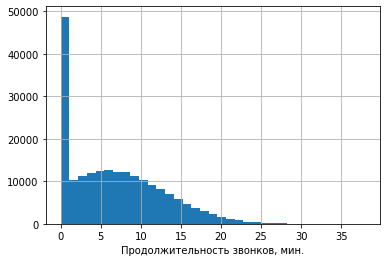

In [145]:
# гистограмма продолжительности звонков:

calls['duration'].hist(bins=35)
plt.xlabel('Продолжительность звонков, мин.');

Подавляющее большинство звонков с нулевой продолжительностью. Согласно исходным данным - это не ошибка: нулём обозначены пропущенные звонки, поэтому не будем их удалять.

### Изучение общей информации об использованном интернет-трафике `sessions` 

[Назад к содержанию](#Содержание)

In [146]:
# вывод общей информации:

sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Признак с датой интернет-сессии `session_date` также сохранен в формате `object`. В дальнейшем приведём этот признак к формату `datetime`.

In [147]:
# вывод первых строк:

sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Выведем гистограмму распределения израсходованного трафика.

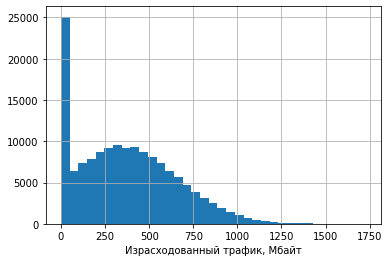

In [148]:
sessions['mb_used'].hist(bins=35)
plt.xlabel('Израсходованный трафик, Мбайт');

### Изучение общей информации об отправленных сообщениях `messages` 

[Назад к содержанию](#Содержание)

In [149]:
# вывод общей информации:

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Признак с датой сообщений `message_date` сохранен в формате `object`. В дальнейшем приведём этот признак к формату `datetime`.

In [150]:
# вывод первых строк:

messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


### Изучение общей информации о тарифах `tariffs`

[Назад к содержанию](#Содержание)

In [151]:
# вывод общей информации:

tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [152]:
# вывод tariffs:

tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Предоставлено два тарифа: "Смарт" и "Ультра".

### Изучение общей информации о пользователях `users` 

[Назад к содержанию](#Содержание)

In [153]:
# вывод общей информации:

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


38 абонентов завершили использование тарифа - признак `churn_date`. Отсутствующие данные в `churn_date` означают, что на момент выгрузки данных тариф абонента работал. Подсчитаем процент клиентов, которые расторгли договор.

In [154]:
users['churn_date'].count() / users['churn_date'].shape[0] * 100

7.6

Расторгли договор 7.6% клиентов из предоставленного датасета `users`.

Признаки с датой прекращения пользования тарифом `churn_date` и с датой подключения тарифа `reg_date` сохранены в формате `object`. В дальнейшем переведём формат данных этих признаков в `datetime'.   

In [155]:
# вывод первых строк:

users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


**Вывод по изучению общей информации**

Изучили общую информацию о предоставленных данных:

   - тип некоторых признаков следует изменить на `datetime`;
   - зафиксировали 38 абонентов, которые прекратили использование своего тарифа - это 7.6% клиентов;
   - предоставлено два тарифных плана: "Смарт" и "Ультра".

## Предобработка данных

[Назад к содержанию](#Содержание)

На этапе изучения данных обнаружили для временных признаков неверный тип данных. Это следующие признаки:

   - `call_date` из датафрейма `calls`;
   - `session_date` из `sessions`;
   - `message_date` из `messages`;
   - `churn_date` и `reg_date` из `users`.

Приведём тип данных к `datetime`.

In [156]:
# перевод временных признаков в datetime:

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
sessions['session_date'] = pd.to_datetime(sessions['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Привели тип временных признаков к формату `datetime`. 

Ещё раз взглянем на предоставленные датасеты.

In [157]:
# вывод первых строк calls:

calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Округлим продолжительность звонков `duration` в большую сторону и приведём тип данных к `integer`.

In [158]:
# округление значений столбца duration:
calls['duration'] = np.ceil(calls['duration'])

# приведение к типу int:
calls['duration'] = calls['duration'].astype (int)

In [159]:
# вывод первых строк sessions:

sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Удалим не нужный признак `Unnamed: 0`.

In [160]:
# удаление признака Unnamed: 0:

sessions = sessions.drop(['Unnamed: 0'], axis=1)

In [161]:
sessions.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [162]:
# вывод первых строк messages:

messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Данные в датафрейме `messages` не требует дальнейшей предобработки.

In [163]:
# вывод первых строк tariffs:

tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Данные в датафрейме tariffs не требует дальнейшей предобработки.

In [164]:
# вывод первых строк users:

users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Данные в датафрейме users не требует дальнейшей предобработки.

**Вывод по предобработке**

   - привели временные признаки к типу `datetime`;
   - избавились от не нужных признаков;
   - округлили продолжительность звонков `duration`` в большую сторону. 

## Добавление новых признаков

[Назад к содержанию](#Содержание)

Для последующего анализа данных нам пригодится информация по суммарному использованию выполненных звонков, потраченных МБайт и отправленных SMS за месяц. Для этого создадим новые признаки `month` в соответствующих датафреймах. 

Добавим новый признак `month` в датафрейме `calls`. Новый признак заполним номером месяца. Номер месяца возьмём из признака `call_date`.

In [165]:
# добавление признака month и заполнение номером месяца:

calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [166]:
# проверка:

calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Аналогичным образом добавим номер месяца для интернет-сессий `session_date` в датафрейме `sessions`.

In [167]:
# добавление признака month и заполнение номером месяца:

sessions['month'] = pd.DatetimeIndex(sessions['session_date']).month

In [168]:
# проверка:

sessions.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Добавим номер месяца для SMS-сообщений

In [169]:
# добавление признака month и заполнение номером месяца:

messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [170]:
# проверка:

messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


## Подсчёт потребляемых услуг

[Назад к содержанию](#Содержание)

В предыдущем пункте мы ввели новые признаки - номер месяца. Теперь мы можем подсчитать для каждого пользователя по месяцам: 

   - количество сделанных звонков;
   - количество израсходованных минут;
   - количество отправленных сообщений;
   - количество потраченных мегабайт.

In [171]:
# подсчёт количества звонков для каждого пользователя по месяцам:

calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count'))

In [172]:
# вывод 30 первых строк на экран

calls_per_month.head(30)

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63
1002    6         15
        7         26
        8         42
        9         36
        10        33
        11        32
        12        33
1003    8         55
        9        134
        10       108
        11       115
        12       108
1004    5          9
        6         31
        7         22
        8         19
        9         26
        10        29
        11        19
        12        21

In [173]:
# подсчёт израсходованных минут для каждого пользователя по месяцам:

minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))

In [174]:
# вывод первых 30 строк на экран

minutes_per_month.head(30)

minutes
user_id month         
1000    5          159
        6          172
        7          340
        8          408
        9          466
        10         350
        11         338
        12         333
1001    11         430
        12         414
1002    6          117
        7          214
        8          289
        9          206
        10         212
        11         243
        12         236
1003    8          380
        9          961
        10         855
        11         824
        12         802
1004    5           35
        6          171
        7          135
        8          137
        9          117
        10         145
        11         117
        12         130

In [175]:
# подсчёт количества отправленных сообщений для каждого пользователя по месяцам:

messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count'))

In [176]:
# вывод первых 30 строк на экран

messages_per_month.head(30)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11
        8            13
        9             4
        10           10
        11           16
        12           12
1003    8            37
        9            91
        10           83
        11           94
        12           75
1004    5            95
        6           134
        7           181
        8           151
        9           146
        10          165
        11          158
        12          162
1005    1             7
        2            38

In [177]:
# подсчёт потраченных мегабайт для каждого пользователя по месяцам:

sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})

In [178]:
# вывод первых 30 строк на экран

sessions_per_month.head(30)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25
        11     18587.28
        12     18113.73
1003    8       8565.21
        9      12468.87
        10     14768.14
        11     11356.89
        12     10121.53
1004    5      13403.98
        6      17600.02
        7      22229.58
        8      28584.37
        9      15109.03
        10     18475.44
        11     15616.02
        12     18021.04

## Анализ данных и подсчёт выручки

[Назад к содержанию](#Содержание)

Объединим все посчитанные выше значения в один датафрейм `user_behavior`.
Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.



In [179]:
# объединяем данные в один датафрейм:

user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,159.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,172.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,340.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,408.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,466.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим пропуски в таблице `user_behavior` после объединения:

In [180]:
# наличие пропусков:

user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Проанализируем пропуски в столбцах `calls`, `messages`, `mb_used`, `minutes` и `churn_date`.

Пропуски в `calls` скорее всего связаны с отсутствием выполненных звонков. Количество пропусков в `calls` соответствует количеству пропусков в `minutes`. Проверим догадку, выведем пропуски в `calls`.

In [181]:
# вывод строк с отсутствующими данными в признаке calls:

user_behavior.query('calls.isna()')

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
570,1091,5,NaN,30.0,10703.37,NaN,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
571,1091,6,NaN,30.0,10236.19,NaN,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
572,1091,7,NaN,35.0,16444.98,NaN,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
573,1091,8,NaN,31.0,12633.88,NaN,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
574,1091,9,NaN,32.0,16597.11,NaN,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
575,1091,10,NaN,44.0,15644.73,NaN,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
576,1091,11,NaN,28.0,11864.25,NaN,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
577,1091,12,NaN,42.0,13280.45,NaN,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
671,1106,4,NaN,9.0,2923.49,NaN,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra
672,1106,5,NaN,28.0,16573.01,NaN,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra


Действительно вызовов не было. Тариф действующий - отсутствуют данные в столбце `churn_date`. Можно отметить большое потребление интернет трафика. Т.е. абоненты используют тариф в основном для интернета. В основном это тариф `ultra`.

Заполним пропуски в `calls`, `minutes` и `churn_date` нулём.

In [182]:
# заполнение пропусков нулём:

user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['churn_date'] = user_behavior['churn_date'].fillna(0)


In [183]:
user_behavior.isna().sum()

user_id         0
month           0
calls           0
messages      497
mb_used        11
minutes         0
age             0
churn_date      0
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Далее выведем строки с пропусками в `messages`.

In [184]:
# вывод строк с отсутствующими данными в признаке messages:

user_behavior.query('messages.isna()')

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
8,1001,11,59.0,NaN,18429.34,430.0,41,0,Москва,Иван,Ежов,2018-11-01,smart
9,1001,12,63.0,NaN,14036.66,414.0,41,0,Москва,Иван,Ежов,2018-11-01,smart
42,1006,2,3.0,NaN,1392.15,42.0,21,0,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
43,1006,3,46.0,NaN,17287.93,286.0,21,0,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
44,1006,4,47.0,NaN,13936.70,356.0,21,0,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,1494,8,32.0,NaN,6590.75,262.0,62,0,Омск,Ренат,Андропов,2018-08-17,smart
3182,1494,9,66.0,NaN,16962.51,501.0,62,0,Омск,Ренат,Андропов,2018-08-17,smart
3183,1494,10,52.0,NaN,17767.24,354.0,62,0,Омск,Ренат,Андропов,2018-08-17,smart
3184,1494,11,63.0,NaN,18052.45,411.0,62,0,Омск,Ренат,Андропов,2018-08-17,smart


Тарифы действующие. Абоненты просто не отправили ни одного SMS-сообщения за месяц. Поэтому заменим отсутствующие данные нулём.

In [185]:
# заполнение пропусков нулём:

user_behavior['messages'] = user_behavior['messages'].fillna(0)

Далее выведем строки с пропусками в `mb_used`.

In [186]:
# вывод строк с отсутствующими данными в признаке messages:

user_behavior.query('mb_used.isna()')

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
1722,1273,5,24.0,21.0,NaN,220.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
1723,1273,6,40.0,38.0,NaN,230.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
1724,1273,7,44.0,37.0,NaN,253.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
1725,1273,8,53.0,41.0,NaN,253.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
1726,1273,9,33.0,32.0,NaN,223.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
1727,1273,10,40.0,35.0,NaN,315.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
1728,1273,11,45.0,29.0,NaN,272.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
1729,1273,12,41.0,39.0,NaN,260.0,46,0,Курган,Рэм,Корнилов,2018-05-15,ultra
2387,1377,2,23.0,2.0,NaN,179.0,59,0,Брянск,Альфред,Семин,2018-02-25,ultra
2500,1392,2,2.0,3.0,NaN,13.0,54,2018-09-27 00:00:00,Челябинск,Алла,Беликова,2018-02-27,ultra


Один абонент перестал пользоваться тарифом. Остальные пользователи не пользовались интернетом, хотя почти у всех абонентов тариф `ultra`.

Также заполним пропуски в `mb_used` нулём.

In [187]:
# заполнение пропусков нулём:

user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

In [188]:
# проверка на пропуски:

user_behavior.isna().sum()

user_id       0
month         0
calls         0
messages      0
mb_used       0
minutes       0
age           0
churn_date    0
city          0
first_name    0
last_name     0
reg_date      0
tariff        0
dtype: int64

Итак, заполнили все пропуски нулём. 

Далее подсчитаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф. Тем самым сможем подсчитать дополнительный доход, который приносят абоненты помимо стоимости тарифного плана. Дополним датафрейм `user_behavior` информацией о тарифных планах из `tariffs`.

In [189]:
# вывод tariffs:

tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переименуем столбец tariff_name на более простое tariff.

In [190]:
# переименование столбца tariff_name на более простое tariff

tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)

Присоединим к `user_behavior` датафрейм `tariffs`.

In [191]:
# присоединение tariffs:

user_behavior = user_behavior.merge(tariffs, on='tariff')

In [192]:
# вывод первых строк user_behavior:

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,22.0,2253.49,159.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,60.0,23233.77,172.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,75.0,14003.64,340.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,81.0,14055.93,408.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,57.0,14568.91,466.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Подсчитаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф. Добавим новые признаки `paid_minutes`, `paid_messages` и `paid_mb`.

In [193]:
# количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф:

user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

In [194]:
# вывод первых строк:

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb
0,1000,5,22.0,22.0,2253.49,159.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2841.0,-978.0,-28466.51
1,1000,6,43.0,60.0,23233.77,172.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2828.0,-940.0,-7486.23
2,1000,7,47.0,75.0,14003.64,340.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2660.0,-925.0,-16716.36
3,1000,8,52.0,81.0,14055.93,408.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2592.0,-919.0,-16664.07
4,1000,9,58.0,57.0,14568.91,466.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,-2534.0,-943.0,-16151.09


В том случае, если лимит звонков, сообщений и интернет-трафик не превышен, мы получили отрицательные значения. Поскольку нас интересует информация о потраченных услугах сверх тарифного плана, то заменим все отрицательные значения нулём. 

In [195]:
# замена отрицательных значений 
# в paid_messages, paid_minutes и paid_mb нулём:

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

In [196]:
# проверка:

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb
0,1000,5,22.0,22.0,2253.49,159.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,6,43.0,60.0,23233.77,172.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,7,47.0,75.0,14003.64,340.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,8,52.0,81.0,14055.93,408.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,9,58.0,57.0,14568.91,466.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0


Получилось.

Выведем несколько строк, в которых абоненты превысили свои лимиты.

In [197]:
user_behavior.query('paid_minutes !=0 & paid_messages != 0 & paid_mb != 0').head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb
1073,1015,7,79.0,90.0,19908.19,556.0,26,0,Челябинск,Рузана,Алюшина,2018-04-30,smart,50,15360,500,550,200,3,3,56.0,40.0,4548.19
1076,1015,10,67.0,68.0,16663.43,577.0,26,0,Челябинск,Рузана,Алюшина,2018-04-30,smart,50,15360,500,550,200,3,3,77.0,18.0,1303.43
1106,1026,12,68.0,57.0,16535.69,531.0,32,0,Мурманск,Евгений,Бородин,2018-10-06,smart,50,15360,500,550,200,3,3,31.0,7.0,1175.69
1117,1029,10,92.0,62.0,21557.92,609.0,51,0,Екатеринбург,Алексей,Селезнев,2018-09-15,smart,50,15360,500,550,200,3,3,109.0,12.0,6197.92
1183,1042,12,121.0,75.0,37165.69,728.0,42,0,Хабаровск,Константин,Добрынин,2018-11-25,smart,50,15360,500,550,200,3,3,228.0,25.0,21805.69


Стоимость дополнительного интернет-трафика `rub_per_gb` указана за гигабайт. Переведём значения `paid_mb`из Мб в Гб. Округлим в большую сторону.

In [198]:
# добавление нового признака paid_gb - 
# объем потраченного интернет-трафика сверх лимита

user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

Подсчитаем выручку за минуты разговора, сообщения и интернет. Создадим дополнительные признаки.

In [199]:
# выручка за минуты разговора, сообщения и интернет
# сверх лимита:

user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

Подсчитаем помесячную выручку с каждого пользователя. Подсчитаем сумму всех затрат:

   - абонентская плата;
   - стоимость дополнительных минут сверх тарифного плана;
   - стоимость дополнительных сообщений;
   - стоимость дополнительного интернет-трафика.
   
Сохраним значения в новом столбце `total_cost`.

In [200]:
# месячная выручка с каждого пользователя,
# включая тарифный план:

user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

In [201]:
# проверка:

user_behavior.query('paid_minutes !=0 & paid_messages != 0 & paid_mb != 0').head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_minutes,paid_messages,paid_mb,paid_gb,cost_minutes,cost_messages,cost_gb,total_cost
1073,1015,7,79.0,90.0,19908.19,556.0,26,0,Челябинск,Рузана,Алюшина,2018-04-30,smart,50,15360,500,550,200,3,3,56.0,40.0,4548.19,5,168.0,120.0,1000,1838.0
1076,1015,10,67.0,68.0,16663.43,577.0,26,0,Челябинск,Рузана,Алюшина,2018-04-30,smart,50,15360,500,550,200,3,3,77.0,18.0,1303.43,2,231.0,54.0,400,1235.0
1106,1026,12,68.0,57.0,16535.69,531.0,32,0,Мурманск,Евгений,Бородин,2018-10-06,smart,50,15360,500,550,200,3,3,31.0,7.0,1175.69,2,93.0,21.0,400,1064.0
1117,1029,10,92.0,62.0,21557.92,609.0,51,0,Екатеринбург,Алексей,Селезнев,2018-09-15,smart,50,15360,500,550,200,3,3,109.0,12.0,6197.92,7,327.0,36.0,1400,2313.0
1183,1042,12,121.0,75.0,37165.69,728.0,42,0,Хабаровск,Константин,Добрынин,2018-11-25,smart,50,15360,500,550,200,3,3,228.0,25.0,21805.69,22,684.0,75.0,4400,5709.0


Далее создадим датафрейм `stats_df`, в котором сохраним для каждой пары "месяц-тариф" среднее значение, стандартное отклонение и медиану для следующих признаков:

   - количество выполненных звонков;
   - количество потраченных минут;
   - количество отправленных SMS;
   - количество потраченных мегабайт.

In [207]:
# сохранение статистических метрик для каждой пары "месяц-тариф"
# среднее значение, стандартное отклонение, медиана

stats_df = user_behavior.pivot_table( \
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

# переименование столбцов:
stats_df.columns=['month', 'tariff', 
                  'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                  'calls_std', 'sessions_std', 'messages_std', 'minutes_std', 
                  'calls_median', 'sessions_median', 'messages_median', 'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,203.85,20.81,6444.68,16.20,154.23,20.5,7096.18,15.0,162.5
1,1,ultra,59.44,13140.68,33.78,428.11,41.64,6865.35,30.67,269.76,51.0,14791.37,32.0,382.0
2,2,smart,40.19,11597.05,24.09,298.69,25.39,6247.35,21.75,190.82,38.5,12553.71,20.0,258.0
3,2,ultra,41.54,11775.94,21.96,297.12,40.97,10644.64,26.77,296.51,25.0,7327.12,5.5,168.0
4,3,smart,54.32,15104.16,31.86,390.05,25.54,5828.24,26.80,191.89,59.0,15670.25,23.0,409.0
5,3,ultra,67.68,17535.55,32.30,489.65,44.84,10951.79,41.62,333.74,57.0,17495.18,20.0,403.0
6,4,smart,51.31,13462.18,30.74,367.13,25.70,5698.25,24.54,186.49,52.0,14087.65,28.0,368.5
7,4,ultra,64.09,16828.13,31.56,458.02,36.27,9718.65,37.51,267.68,61.0,16645.78,17.0,453.0
8,5,smart,55.24,15805.18,33.77,387.36,25.38,5978.23,27.04,186.60,59.0,16323.94,30.0,433.0
9,5,ultra,72.51,19363.15,37.85,510.33,41.08,10046.11,40.31,289.60,75.0,18696.43,25.0,519.0


### Анализ выполненных звонков

[Назад к содержанию](#Содержание)

Построим график распределения среднего количества звонков по видам тарифов и месяцам.

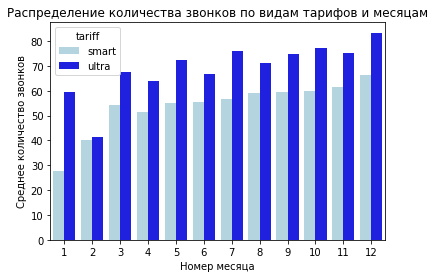

In [210]:
# распределение среднего количества звонков по видам тарифов и месяцам:

ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение количества звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

Среднее количество выполненных звонков больше у тех кто пользуется тарифом `ultra` чем у кого тариф `smart`. Что весьма логично.

Данный график не отображает число абонентов, а хотелось бы иметь об этом представление. Построим соответствующий график зависимости между количеством выполненных звонков и количеством клиентов в зависимости от выбранного тарифного плана. 

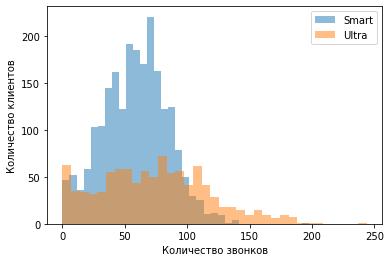

In [213]:
# количество выполненных звонков и абонентов
# в зависимости от тарифа:

user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов')
plt.show()

Количество абонентов тарифа `smart` превосходит количество клиентов тарифа `ultra`. Но количество выполненных звонков гораздо больше на тарифе `ultra`. 

Построим распределение средней продолжительности звонков по видам тарифов и месяцам.

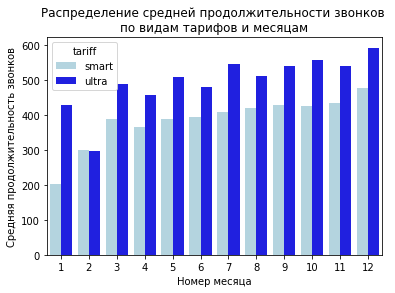

In [221]:
# средняя продолжительность звонков по месяцам:

ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение средней продолжительности звонков \nпо видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

В феврале можно отметить почти одинаковую среднюю продолжительность звонков у тарифов `smart` и `ultra`. Также в феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели. Во всех остальных месяцах средняя продолжительность звонков выше у тарифа `ultra`.

Выведем график зависимости между количеством израсходованных минут и количеством абонентов с учётом тарифного плана. 


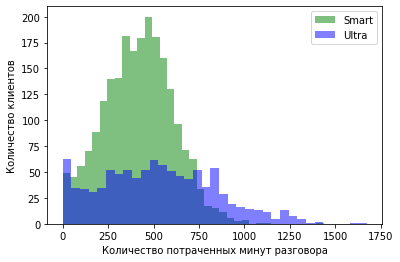

In [234]:
# количество израсходованных минут по числу абонентов
# по каждому тарифному плану:

user_behavior[user_behavior['tariff'] == 'smart']['minutes'].\
    plot(kind='hist', bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] == 'ultra']['minutes']. \
    plot(kind='hist', bins=35, alpha=0.5, color='blue')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество потраченных минут разговора')
plt.ylabel('Количество клиентов')
plt.show()

Абоненты тарифного плана `ultra` тратят гораздо большее количество минут по сравнению с абонентами, у которых тарифный план `smart`. Но таких абонентов не много. Выведем численные показатели.
 

In [242]:
# обзор количества потраченных минут для тарифа `smart`:

user_behavior[user_behavior['tariff'] == 'smart']['minutes'].describe()

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: minutes, dtype: float64

In [238]:
# обзор количества потраченных минут для тарифа `ultra`:

user_behavior[user_behavior['tariff'] == 'ultra']['minutes'].describe()

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: minutes, dtype: float64

**Выводы по выполненным звонкам в зависимости от тарифного плана:**

   - среднее количество выполненных звонков больше у тех кто пользуется тарифом `ultra` чем у кого тариф `smart`;
   - количество абонентов тарифа `smart` превосходит количество клиентов тарифа `ultra`;
   - количество выполненных звонков гораздо больше на тарифе `ultra`;
   - средняя длительность разговоров у абонентов тарифа `ultra` больше, чем у абонентов тарифа `smart`;
   - в течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. 

Далее проведём аналогичный анализ для SMS-сообщений. Построим распределение среднего количества сообщений по видам тарифов и месяцам.

### Анализ отправленных SMS-сообщений

[Назад к содержанию](#Содержание)

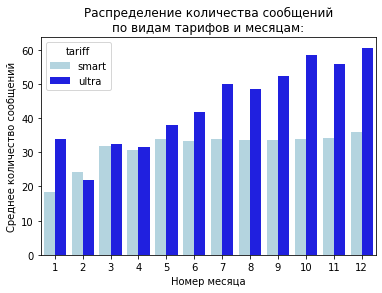

In [249]:
# распределение количества сообщений по видам тарифов и месяцам:

ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества сообщений\nпо видам тарифов и месяцам:')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

Среднее количество отправленных SMS-сообщений тарифа `smart` почти весь год практически одинаковое. Меньше всего в январе и феврале.

У пользователей тарифа `ultra` среднее количество сообщений растёт в течение года.

В целом абоненты тарифа `ultra` отправляют больше SMS.

Но мы знаем, что клиентов с тарифным планом `ultra` меньше, чем абонентов со `smart` тарифом. Построим график, отображающий количество отправленных SMS и количество абонентов по каждому тарифу. 



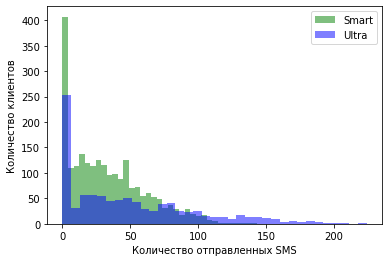

In [256]:
# количество отправленных SMS по числу абонентов
# по каждому тарифному плану:

user_behavior[user_behavior['tariff'] =='smart']['messages']. \
    plot(kind='hist', bins=35, alpha=0.5, color='green')

user_behavior[user_behavior['tariff'] =='ultra']['messages'].\
    plot(kind='hist', bins=35, alpha=0.5, color='blue')

plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество отправленных SMS')
plt.ylabel('Количество клиентов')
plt.show()

Итак, пользователи `ultra` отправляют большее количество сообщений, но по сравнению с тарифом `smart` их намного меньше.

In [251]:
# обзор количества отправленных SMS для тарифа `smart`:

user_behavior[user_behavior['tariff'] == 'smart']['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [253]:
# обзор количества отправленных SMS для тарифа `ultra`:

user_behavior[user_behavior['tariff'] == 'ultra']['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

**Выводы по отправленным SMS в зависимости от тарифного плана:**

   - пользователи тарифа `ultra` отправляют в среднем почти на 20 SMS больше;
   - у пользователей тарифа `ultra` среднее количество сообщений растёт в течение года;
   - среднее количество отправленных SMS-сообщений тарифа `smart` почти весь год практически одинаковое.
   
Далее проведем анализ потребления интернет-трафика.

### Анализ потребления интернет-трафика

[Назад к содержанию](#Содержание)

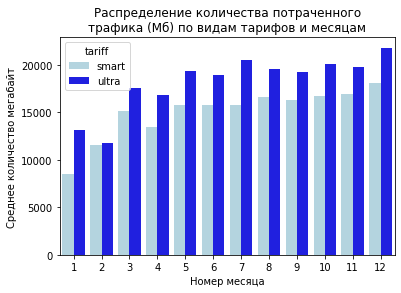

In [255]:
# распределение потраченного трафика:

ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества потраченного\nтрафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

Абоненты `ultra` тратят больше интернет-трафика. В течение года среднее потребление трафика практически одинаковое, за исключением января и февраля.

На тарифе `smart` пользуются интернетом меньше. Потребление в течение года также практически одинаковое, кроме января и февраля.

Сравним потребление трафика с учетом количества пользователей.

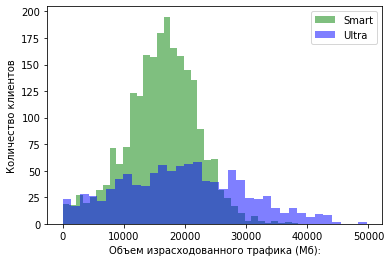

In [257]:
# объём трафика по числу абонентов
# по каждому тарифному плану:

user_behavior[user_behavior['tariff'] =='smart']['mb_used']. \
    plot(kind='hist', bins=35, alpha=0.5, color='green')

user_behavior[user_behavior['tariff'] =='ultra']['mb_used']. \
    plot(kind='hist', bins=35, alpha=0.5, color='blue')

plt.legend(['Smart', 'Ultra'])
plt.xlabel('Объем израсходованного трафика (Мб):')
plt.ylabel('Количество клиентов')
plt.show()

На тарифе `ultra` тратят больше интернет-трафика. Но по сравнению с тарифом `smart` таких клиентов совсем не много. 

In [260]:
# обзор использования интернета для тарифа `smart`:

user_behavior[user_behavior['tariff'] == 'smart']['mb_used'].describe()

count     2229.000000
mean     16208.386990
std       5870.476681
min          0.000000
25%      12643.010000
50%      16506.840000
75%      20042.930000
max      38552.450000
Name: mb_used, dtype: float64

In [261]:
# обзор использования интернета для тарифа `ultra`:

user_behavior[user_behavior['tariff'] == 'ultra']['mb_used'].describe()

count      985.000000
mean     19468.805208
std      10087.170752
min          0.000000
25%      11770.260000
50%      19308.010000
75%      26837.690000
max      49745.690000
Name: mb_used, dtype: float64

**Выводы по использованию интернет-трафика в зависимости от тарифного плана:**

   - абоненты `ultra` тратят больше интернет-трафика;
   - абонентов `ultra` меньше чем `smart`;
   - в течение года среднее потребление трафика практически одинаковое, за исключением января и февраля, для обоих тарифных планов.

## Проверка гипотез

[Назад к содержанию](#Содержание)

Проверим различается ли средняя выручка пользователей тарифов `ultra` и `smart`.

Для чего сформулируем гипотезу: средняя выручка пользователей тарифов `ultra` и `smart` различаются.

Нулевая гипотеза:

   - H_0: Выручка пользователей `ultra` равна выручке пользователей `smart`.

Альтернативная гипотеза:

   - H_1: Выручка пользователей `ultra` не равна выручке пользователей `smart`.

Уровень значимости зададим равным 0.05.

In [272]:
# проверка гипотез:

ultra_total_cost = user_behavior[user_behavior['tariff'] == 'ultra']['total_cost']
smart_total_cost = user_behavior[user_behavior['tariff'] == 'smart']['total_cost']

results = st.ttest_ind(
    ultra_total_cost,
    smart_total_cost,
    equal_var = False
)

# значение уровня значимости:
alpha = 0.05

# вывод значения p-value: 
print('p-value: ', results.pvalue)

# вывод результата проверки гипотезы:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Итак, мы получили значение p-value практически равное нулю. Это означает, что средняя выручка пользователей `ultra` не равна от выручки тарифа `smart`.

Выведем значения средней выручки для обоих тарифных планов.



In [270]:
# средняя выручка тарифа `ultra` (руб):

ultra_total_cost.mean()

2070.1522842639592

In [271]:
# средняя выручка тарифа `smart` (руб):

smart_total_cost.mean()

1289.9735307312696

Итак, средняя выручка тарифного плана `ultra` действительно выше выручки со `smart` тарифа.

Далее проверим ещё одну гипотезу: пользователи из Москвы приносят больше выручки, чем пользователи из других городов.

Нулевая гипотеза:

   - H_0: Выручка пользователей из Москвы равна выручке пользователей не из Москвы.
    
Альтернативная гипотеза:    

   - H_1: Выручка пользователей из Москвы не равна выручке пользователей не из Москвы.
    
    
Уровень значимости зададим равным 0.05.

In [264]:
# проверка гипотез:

msc_total_cost = user_behavior[user_behavior['city'] =='Москва']['total_cost']
other_total_cost = user_behavior[user_behavior['tariff'] !='Москва']['total_cost']

results = st.ttest_ind(
    msc_total_cost,
    other_total_cost,
    equal_var = False
)

# значение уровня значимости:
alpha = 0.05

# вывод значения p-value: 
print('p-значение: ', results.pvalue)

# вывод результата проверки гипотезы:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5989670526299276
Не получилось отвергнуть нулевую гипотезу


p-value больше заданного порога. Это означает, что московские абоненты действительно приносят большую выручку.

Выведем значения средней выручки для абонентов из Москвы и из других городов.

In [274]:
# средняя выручка с московских абонентов (руб):

msc_total_cost.mean()

1546.7135842880523

In [275]:
# средняя выручка с абонентов не из Москвы (руб):

other_total_cost.mean()

1529.0762289981333

Московские абоненты действительно приносят больший доход по сравнению с абонентами из других городов.

**Выводы после проверки гипотез**

Сформулировали и проверили две гипотезы:

   1. Средняя выручка не различается в зависимости от тарифного плана. Эта гипотеза оказалась ложной.
   2. Пользователи из Москвы приносят больше выручки, чем пользователи из других городов. Это действительно так.

## Вывод

[Назад к содержанию](#Содержание)

В ходе проведенного анализа можно сделать следующие выводы:

   - самым прибыльным тарифом является тариф "Ультра";
   - в Москве абоненты приносят наибольший доход.
   
Коммерческому департаменту стоит оперировать полученными выводами при корректировке рекламного бюджета.